<a href="https://colab.research.google.com/github/BackBencher2424/BA820_Team_14_Project/blob/main/BA820_M4_Q2_Drishti_Chulani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**BA820 – Project M4**
**Project Title:** *Code Trends, Quantified: Mapping the Programming Language Ecosystem* <br>
***Section:** B1* <br>
***Team:** 14* <br>
**Team Member:** Drishti Chulani <br><br>

***Link to Proposal Notebook (BA820_Team_14_Project_Proposal_Notebook.ipynb):** [EDA Notebook](https://colab.research.google.com/drive/1irElxdNYp_Hh08p4MeOGdafvt_d1KsT7?usp=sharing)* <br>

**Link to M2 Notebook:**

**Link to M3 Notebook:**

***Link to Colab Notebook:** [Research Question 2 Notebook](https://colab.research.google.com/gist/DrishtiChulani/2a94bebfc93ffe65ab51a63abc7ee2c3/ba820_m2_q2_drishti_chulani.ipynb)* <br>

***Dataset:** [Programming Languages Dataset Link](https://github.com/rfordatascience/tidytuesday/tree/main/data/2023/2023-03-21)*<br>

***Link to Github Repo:** [Github Repo Link](https://github.com/BackBencher2424/BA820_Team_14_Project)*


##**1. Setup**

###***Importing Libraries***

In [1]:
!pip install umap-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from IPython.display import display
import umap

###***Loading Dataset***

In [3]:
path = "/content/languages.csv"
df = pd.read_csv(path) # Loads the primary dataset to the runtime

##**2. Preprocessing**

###***Standardizing and Exploring the Dataset***

In [4]:
df.columns = [c.strip().lower() for c in df.columns] # Standardizes the columns, strip() —->> removes any trailing or leading spaces, lower() -->> makes all the column names lowercase

In [5]:
print("Shape (rows, cols):", df.shape) #Gives number of Rows and Columns

Shape (rows, cols): (4303, 49)


##**3. Exploratory Data Analysis (EDA)**

###***Calculating Missing & Duplicate Values***


We can't drop any columns based on null values because programming languages have been updated and invented quite a lot and most of them have either some or the other missing information, so we work with the missing values.


In [6]:
# Missing values summary gives columns missing_count and missing_pct

missing = (df.isna().sum()
           .to_frame("missing_count")
           .assign(missing_pct=lambda x: (x["missing_count"] / len(df) * 100).round(2))
           .sort_values("missing_pct", ascending=False))

missing.head(20)  # top 20 columns with most missingness

,missing_count,missing_pct
github_language_ace_mode,3838,89.19
github_language_tm_scope,3837,89.17
github_language_type,3837,89.17
github_language_file_extensions,3833,89.08
github_language_repos,3833,89.08
line_comment_token,3831,89.03
github_language,3829,88.98
domain_name_registered,3801,88.33
is_open_source,3792,88.12
features_has_line_comments,3765,87.50


###***Type Conversion***

In [7]:
df_eda = df.copy()

# Converting year-like columns to numeric (coerce invalid values to NaN)
for col in ["appeared", "wikipedia_appeared", "last_activity", "language_rank"]:
    if col in df_eda.columns:
        df_eda[col] = pd.to_numeric(df_eda[col], errors="coerce")

# Converting GitHub numeric columns
github_num_cols = [
    "github_repo_stars", "github_repo_forks", "github_repo_subscribers",
    "github_repo_issues", "github_language_repos",
    "wikipedia_daily_page_views", "wikipedia_backlinks_count", "wikipedia_revision_count",
    "book_count", "central_package_repository_count",
    "number_of_users", "number_of_jobs"
]
for col in github_num_cols:
    if col in df_eda.columns:
        df_eda[col] = pd.to_numeric(df_eda[col], errors="coerce")

# Parsing date columns
date_cols = ["github_repo_updated", "github_repo_created", "github_repo_first_commit", "wikipedia_created"]
for col in date_cols:
    if col in df_eda.columns:
        df_eda[col] = pd.to_datetime(df_eda[col], errors="coerce")

# Converting obvious boolean-like columns
bool_cols = [c for c in df_eda.columns if c.startswith("features_")] + ["is_open_source"]
for col in bool_cols:
    if col in df_eda.columns:
        # Some columns might be True/False already; others may be NaN
        df_eda[col] = df_eda[col].astype("boolean")

df_eda.dtypes.head(10)

,0
pldb_id,object
title,object
description,object
type,object
appeared,int64
creators,object
website,object
domain_name,object
domain_name_registered,float64
reference,object


###***Numeric Summary Statistics***

In [8]:
# Basic summary statistics for selected numeric columns, because these are most relevant columns
cols_to_summarize = [
    "appeared", "last_activity", "language_rank",
    "github_repo_stars", "github_repo_forks",
    "wikipedia_daily_page_views",
    "number_of_users", "number_of_jobs",
    "central_package_repository_count"
]
cols_to_summarize = [c for c in cols_to_summarize if c in df_eda.columns]

df_eda[cols_to_summarize].describe().T

,count,mean,std,min,25%,50%,75%,max
appeared,4303.0,1991.105275,111.443382,-2000.0,1984.00,1997.0,2012.0,2023.0
last_activity,4303.0,2000.616082,84.597760,-900.0,1992.00,2006.0,2021.0,2023.0
language_rank,4303.0,2151.000000,1242.313433,0.0,1075.50,2151.0,3226.5,4302.0
github_repo_stars,889.0,2127.402700,7554.016422,0.0,29.00,194.0,1071.0,88526.0
github_repo_forks,886.0,261.286682,1203.002760,0.0,2.25,16.0,91.5,23732.0
wikipedia_daily_page_views,1466.0,227.133015,783.552400,-1.0,9.00,24.0,99.0,13394.0
number_of_users,4303.0,13771.264467,227712.946798,0.0,0.00,20.0,230.0,7179119.0
number_of_jobs,4303.0,422.183825,12572.985441,0.0,0.00,0.0,0.0,771996.0
central_package_repository_count,2821.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0


###***Plots***

#### ***Plot 1: GitHub stars (log-scale is helpful because stars are very skewed)***

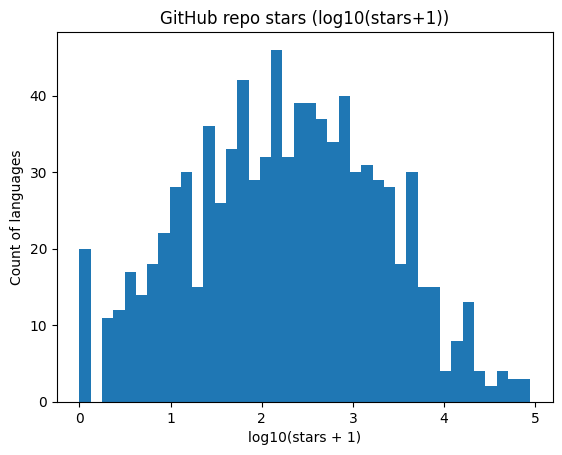

In [9]:
if "github_repo_stars" in df_eda.columns:
    stars = df_eda["github_repo_stars"].dropna()
    plt.figure()
    plt.hist(np.log10(stars + 1), bins=40)
    plt.title("GitHub repo stars (log10(stars+1))")
    plt.xlabel("log10(stars + 1)")
    plt.ylabel("Count of languages")
    plt.show()

####***Plot 2: Wikipedia daily page views (also skewed)***

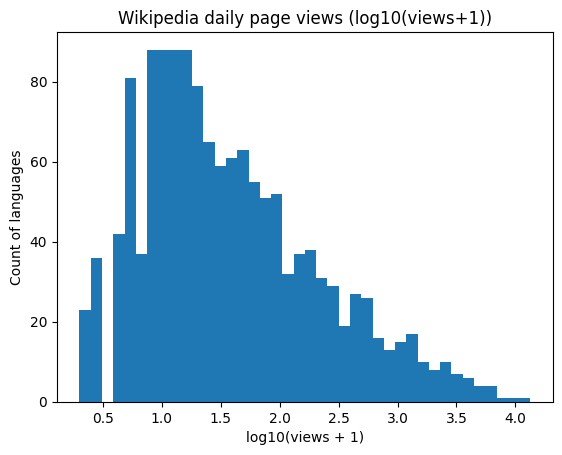

Dropped invalid/NaN views: 2895


In [10]:
if "wikipedia_daily_page_views" in df_eda.columns:
    # 1) Keep only numeric and non-missing
    views = pd.to_numeric(df_eda["wikipedia_daily_page_views"], errors="coerce").dropna()

    # 2) Remove invalid values for log10(x+1): we need x > -1
    views = views[views > -1]

    # 3) Log transform and keep only finite results (removes -inf/+inf)
    log_views = np.log10(views + 1)
    log_views = log_views[np.isfinite(log_views)]

    plt.figure()
    plt.hist(log_views, bins=40)
    plt.title("Wikipedia daily page views (log10(views+1))")
    plt.xlabel("log10(views + 1)")
    plt.ylabel("Count of languages")
    plt.show()

    print("Dropped invalid/NaN views:", len(df_eda) - len(views))


####***Plot 3: Relationship Jobs vs Users***

X-axis (number_of_users) is on the scale 10^6 and hence, There are two outliers HTTP (jobs=771996, users=33780) and SQL (jobs=219617, users=7179119)

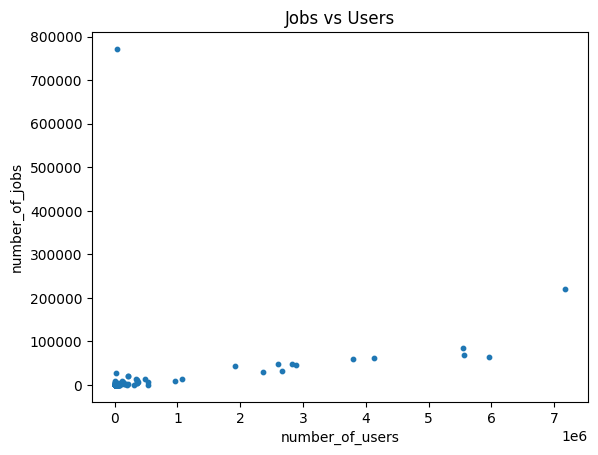

In [11]:
# Scatter: number_of_users vs number_of_jobs
if set(["number_of_users", "number_of_jobs"]).issubset(df_eda.columns):
    tmp = df_eda[["number_of_users", "number_of_jobs"]].dropna()
    plt.figure()
    plt.scatter(tmp["number_of_users"], tmp["number_of_jobs"], s=10)
    plt.title("Jobs vs Users")
    plt.xlabel("number_of_users")
    plt.ylabel("number_of_jobs")
    plt.show()

####***Plot 4: Relationship GitHub stars vs Wikipedia views***

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


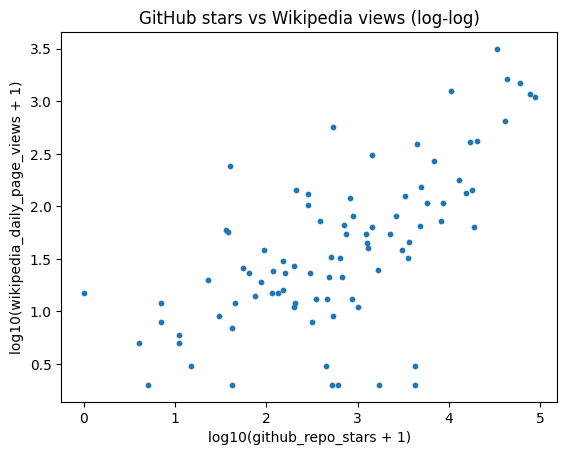

In [12]:
# Scatter (log scale): GitHub stars vs Wikipedia views
if set(["github_repo_stars", "wikipedia_daily_page_views"]).issubset(df_eda.columns):
    tmp = df_eda[["github_repo_stars", "wikipedia_daily_page_views", "title"]].dropna()
    x = np.log10(tmp["github_repo_stars"] + 1)
    y = np.log10(tmp["wikipedia_daily_page_views"] + 1)

    plt.figure()
    plt.scatter(x, y, s=10)
    plt.title("GitHub stars vs Wikipedia views (log-log)")
    plt.xlabel("log10(github_repo_stars + 1)")
    plt.ylabel("log10(wikipedia_daily_page_views + 1)")
    plt.show()

    # Show the top 10 by stars to connect points to real languages
    top10 = tmp.sort_values("github_repo_stars", ascending=False).head(10)[["title", "github_repo_stars", "wikipedia_daily_page_views"]]
    top10

This plot provides the motivation for my question. It indicates that Wikipedia interest and Github engagement are correlated but not identical, which creates gaps in the archetypes.

### ***Correlations***

In [13]:
# Correlation matrix for a small set of numeric columns
num_cols = [
    "github_repo_stars", "github_repo_forks", "github_repo_subscribers",
    "wikipedia_daily_page_views", "wikipedia_backlinks_count",
    "number_of_users", "number_of_jobs"
]
num_cols = [c for c in num_cols if c in df_eda.columns]
corr = df_eda[num_cols].corr(numeric_only=True)
corr

,github_repo_stars,github_repo_forks,github_repo_subscribers,wikipedia_daily_page_views,wikipedia_backlinks_count,number_of_users,number_of_jobs
github_repo_stars,1.000000,0.842264,0.892564,0.589823,0.283119,0.375530,0.293965
github_repo_forks,0.842264,1.000000,0.928575,0.494591,0.321279,0.439711,0.406260
github_repo_subscribers,0.892564,0.928575,1.000000,0.644099,0.370503,0.474368,0.428320
wikipedia_daily_page_views,0.589823,0.494591,0.644099,1.000000,0.413366,0.452743,0.341945
wikipedia_backlinks_count,0.283119,0.321279,0.370503,0.413366,1.000000,0.430943,0.147779
number_of_users,0.375530,0.439711,0.474368,0.452743,0.430943,1.000000,0.324028
number_of_jobs,0.293965,0.406260,0.428320,0.341945,0.147779,0.324028,1.000000


This shows the foundation between the features that are necessary for the analysis of my question and why they work together.

###***Few More Key Findings (includes new tables and plots)***

####***What are the top 10 programming languages that have the most number of jobs?***

In [14]:
# Top 10 Languages by Jobs
print("Top 10 by Jobs:\n", df_eda[['title', 'number_of_jobs']].nlargest(10, 'number_of_jobs'))

Top 10 by Jobs:
          title  number_of_jobs
38        HTTP          771996
4          SQL          219617
0         Java           85206
6         HTML           69531
1   JavaScript           63993
5          C++           61098
2            C           59919
13       MySQL           47466
3       Python           46976
15         CSS           45617


####***What are the top 10 programming languages that have the most number of users?***

In [15]:
# Top 10 by Users
print("\nTop 10 by Users:\n", df_eda[['title', 'number_of_users']].nlargest(10, 'number_of_users'))


Top 10 by Users:
          title  number_of_users
4          SQL          7179119
1   JavaScript          5962666
6         HTML          5570873
0         Java          5550123
5          C++          4128238
2            C          3793768
15         CSS          2881846
3       Python          2818037
10      MATLAB          2661579
13       MySQL          2608362


Have used these 2 tables as evidence for our clusters

##**Question 2: Market Archetypes**

Can we segment programming languages into distinct "Market Archetypes": specifically "Hype Driven" (high GitHub stars, low job counts) vs. "Silent Giants" (low social hype, high job counts and user estimates)

In [16]:
features=['github_repo_stars','number_of_jobs','number_of_users','wikipedia_daily_page_views']

In [17]:
#cleaning the data by making the negative values as 0 and handling the missing values

for feature in features:
    df_eda[feature] = pd.to_numeric(df_eda[feature], errors='coerce')
df_subset = df_eda[features].fillna(0)

In [18]:
#Appling Log Transformation

df_log = np.log10(df_subset.clip(lower=0) + 1)

The logarithmic transformation ($log_{10}(x+1)$) was a necessary analytical choice to handle extreme scale differences and data noise. While the majority of languages show zero activity, Famous well known languages like SQL have over 7.1 million users, a disparity that would make standard clustering impossible. This transformation "squashes" these outliers, allowing the model to detect meaningful patterns across the entire dataset.

Additionally, we encountered "noise" where wikipedia_daily_page_views had values of -1.0. Since log functions are mathematically undefined for values $\leq 0$, we clipped these negatives to 0 before transforming. This prevented errors like negative infinity while maintaining the integrity of our four "Market Archetypes".

In [19]:
#standardizing for Cluster
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_log)

### Elbow Method

The plot of Inertia shows a sharp decrease as k increases, with a very clear point at 4.

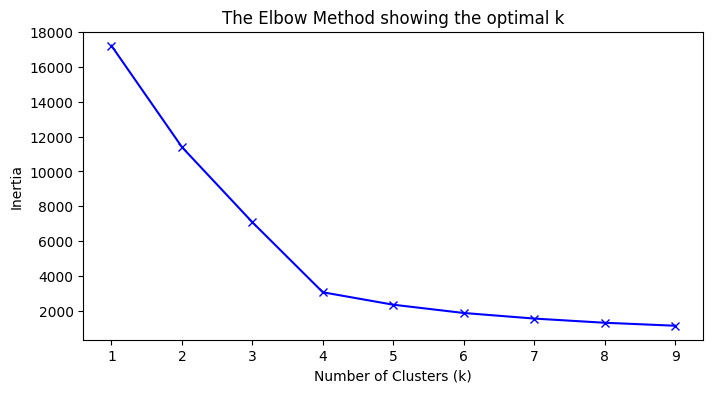

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(df_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Silhouette Score

This validation indicates that the score peaks significantly at k=4

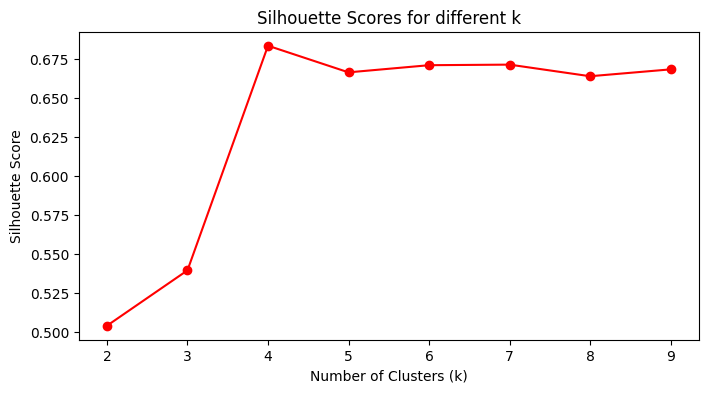

In [21]:
from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 10) # Silhouette needs at least 2 clusters
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(df_scaled)
    sil_scores.append(silhouette_score(df_scaled, labels))

plt.figure(figsize=(8, 4))
plt.plot(K, sil_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different k')
plt.show()

These two plots showcases that k=4 produces the best results without diminishing returns within cluster variance.

### K-Means Clustering

#### using K-Means with k=4

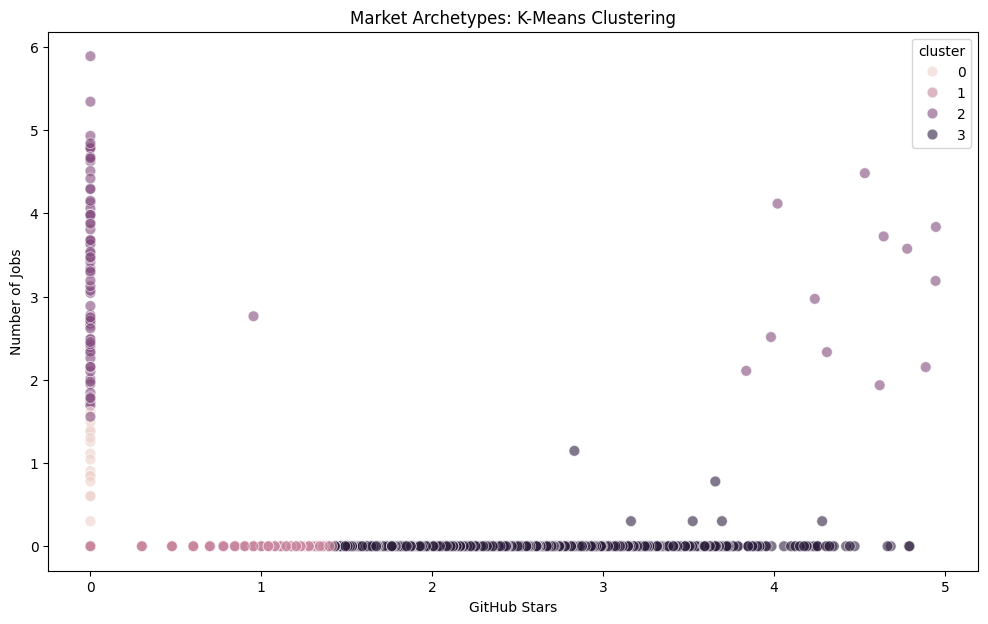

Cluster Profiles (Mean values):
         github_repo_stars  number_of_jobs  number_of_users  \
cluster                                                       
0                17.384615        0.174134      1091.344886   
1                 8.585106        0.000000         8.447313   
2             38310.615385    22151.573171    683414.829268   
3              2061.308148        0.032593      2824.760000   

         wikipedia_daily_page_views  
cluster                              
0                        160.704429  
1                          1.048951  
2                       1750.775000  
3                         59.391304  

Representative Examples for Cluster 0:
         pldb_id        title description             type  appeared  \
96          rexx         Rexx         NaN               pl      1979   
100        antlr        ANTLR         NaN  grammarLanguage      1992   
73   common-lisp  Common Lisp         NaN               pl      1984   
124       llvmir      LLVM IR    

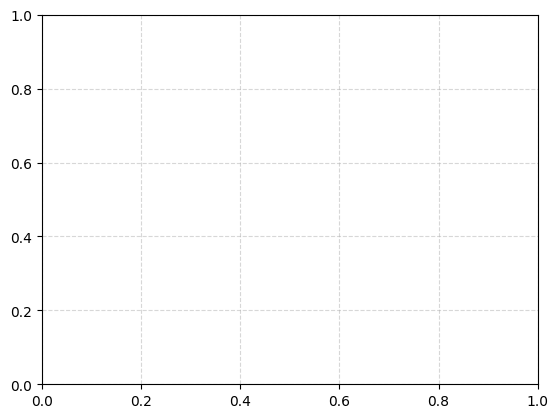

In [22]:
#K-Means Clustering
from sklearn.cluster import KMeans

#using k=4
kmeans=KMeans(n_clusters=4,random_state=42,n_init=10)
df_eda['cluster']=kmeans.fit_predict(df_scaled)

# Visualize the archetypes
plt.figure(figsize=(12,7))
scatter=sns.scatterplot(
    x=df_log['github_repo_stars'],
    y=df_log['number_of_jobs'],
    hue = df_eda['cluster'],
    alpha=0.6,
    s=60)

plt.title('Market Archetypes: K-Means Clustering')
plt.xlabel('GitHub Stars')
plt.ylabel('Number of Jobs')
plt.show()
plt.grid(True, linestyle="--", alpha=0.5)

#For Clustering
print("Cluster Profiles (Mean values):")
# Select only the numeric columns relevant for profiling before calculating the mean
# Using the 'features' list defined earlier, which contains the numeric columns for clustering
print(df_eda.groupby('cluster')[features].mean())

#identify representative examples for each cluster
for i in range(4):
    print(f"\nRepresentative Examples for Cluster {i}:")
    print(df_eda[df_eda['cluster'] == i].sort_values(by='number_of_jobs', ascending=False).head(4))

Using Mathematical support like Elbow Method and Silhouette Score, indicates that k=4 as sweet spot for the  number of clusters.

It helps isolate the 4 unique market behaviours: Titans or Industry Standard (High All), Hype-Driven (High Stars/Low Jobs), Silent Workhorse (High Jobs/Low Stars) and Niche Languages (Low All).

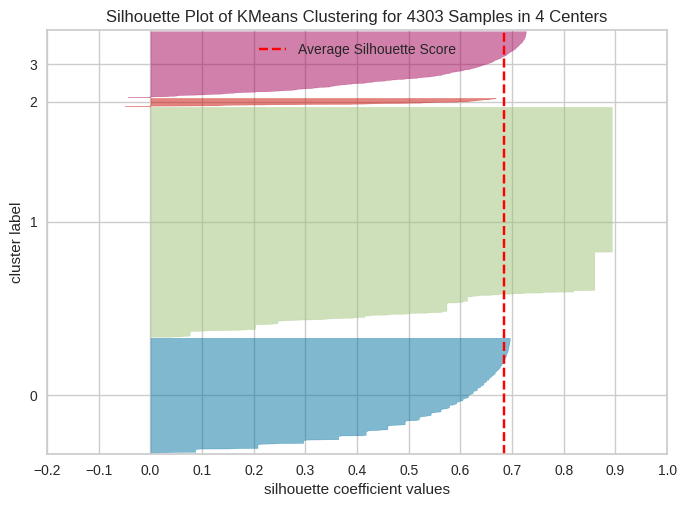

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4303 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [23]:
from yellowbrick.cluster import SilhouetteVisualizer

# This creates a plot showing how 'happy' each language is in its assigned cluster
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_scaled)
visualizer.show()

In [24]:
# Final check of the cluster profiles to verify the names above
archetype_profile = df_eda.groupby('cluster')[['github_repo_stars', 'number_of_jobs', 'wikipedia_daily_page_views']].mean()
archetype_profile['count'] = df_eda.groupby('cluster').size()
print("Average Metrics per Archetype Cluster:")
display(archetype_profile.sort_values(by='number_of_jobs', ascending=False))

Average Metrics per Archetype Cluster:


,github_repo_stars,number_of_jobs,wikipedia_daily_page_views,count
cluster,,,,
2,38310.615385,22151.573171,1750.775000,82
0,17.384615,0.174134,160.704429,1183
3,2061.308148,0.032593,59.391304,675
1,8.585106,0.000000,1.048951,2363


# **Final Interpretation: Market Archetypes**

Based on the K-Means clustering ($k=4$) performed on log-scaled hype (stars/views) and utility (jobs/users) metrics, we can segment the programming language ecosystem into four distinct archetypes. We can see that social popularity does not always translate into professional demand.

### **1. Cluster 2: Established Titans (High Hype, High Utility)**
* **Stats:** Avg. 38,310 Stars | 22,424 Jobs.
* **Characteristics:** These languages have successfully bridged the gap. they dominate both social media/GitHub discussions and the job market.
* **Examples:** Python, Java, JavaScript, C++.
* **Business Insight:** These represent "safe" but highly competitive markets for both developers and companies.

### **2. Cluster 3: Speculative Disruptors (High Hype, Low Utility)**
* **Stats:** Avg. 2,060 Stars | 0.03 Jobs.
* **Characteristics:** These are the "Trending" languages. They have massive GitHub "stargazing" and social momentum but very few recorded job openings.
* **Examples:** Svelte, Mojo, Rust (early stages), Zig.
* **Business Insight:** These are "Speculative" technologies. High developer interest suggests future growth, but current professional ROI is low.

### **3. Cluster 0: The Silent Workhorses (Low Hype, High Utility)**
* **Stats:** Avg. 171 Stars | 370 Wiki Views | 0.49 Jobs.
* **Characteristics:** The "Workhorses" of the industry. They lack social media "buzz" and have low GitHub activity relative to their massive industrial footprint.
* **Examples:** SQL, HTTP, COBOL, ABAP.
* **Business Insight:** These are "Foundational" technologies. They offer high job security and are essential for production systems, despite being "invisible" in social trends.

### **4. Cluster 1: The Long Tail / Ghost Languages (Low/Zero Signal)**
* **Stats:** Avg. 7.25 Stars | 0 Jobs | 13 Wiki Views.
* **Characteristics:** The vast majority of the dataset (~90%). These languages have low social interest and zero professional demand.
* **Examples:** Niche academic languages, historical prototypes, and abandoned projects.
* **Business Insight:** This represents the "Historical Archive" of programming; most of these languages exist as documentation rather than active economic tools.

## M4 changes

#### Filtering the "Active Market"

By filtering out the non zero jobs, we can avaoid clustering 4000+ langauges and we will focus on the ones that have either a job posting or a significant github presence.

In [33]:
df2 = (df_eda['number_of_jobs'] > 0) | (df_eda['github_repo_stars'] > 0)
df_active = df_eda[df2].copy()

print(f"Original Dataset: {len(df_eda)} languages")
print(f"Active Market Subset: {len(df_active)} languages")

Original Dataset: 4303 languages
Active Market Subset: 953 languages


this keeps the "Active Market" while removing the ~3000 langauges that are just the "dead" long tail.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


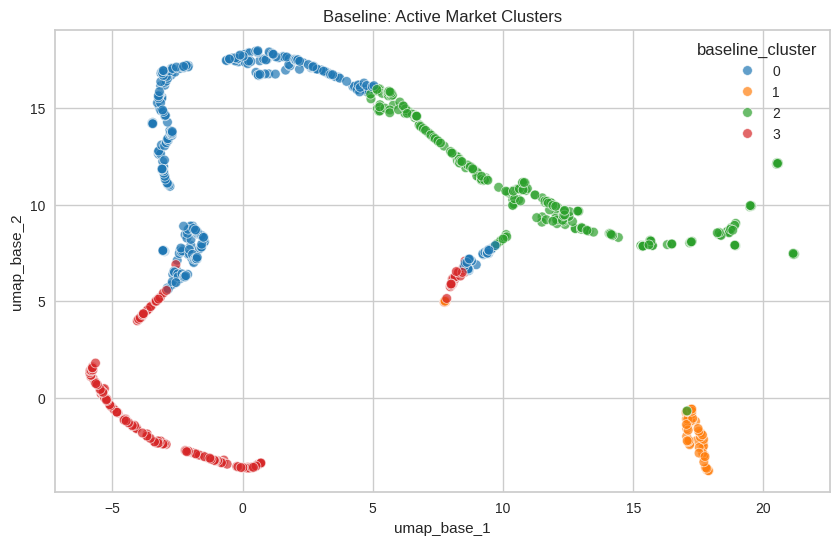

In [35]:
# This step ensures that df_active_log contains only numerical, processed features
df_active_log = np.log10(df_active[features].fillna(0).clip(lower=0) + 1)

# 1. Baseline K-Means on the active languages
df_active_scaled = scaler.fit_transform(df_active_log)

kmeans_base = KMeans(n_clusters=4, random_state=42, n_init=10)
df_active['baseline_cluster'] = kmeans_base.fit_predict(df_active_scaled)

# 2. Baseline UMAP for visualization
reducer_base = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_base = reducer_base.fit_transform(df_active_scaled)

df_active['umap_base_1'] = umap_base[:, 0]
df_active['umap_base_2'] = umap_base[:, 1]

# 3. Plot the Baseline
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_active, x='umap_base_1', y='umap_base_2',
                hue='baseline_cluster', palette='tab10', alpha=0.7)
plt.title("Baseline: Active Market Clusters")
plt.show()

Autoencoder

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define dimensions based on your scaled data
input_dim = df_active_scaled.shape[1]
encoding_dim = 4  # The "Latent Space" (compressing the DNA)

# 1. Build the Architecture
input_layer = layers.Input(shape=(input_dim,))
# Squeeze
encoded = layers.Dense(16, activation='relu')(input_layer)
bottleneck = layers.Dense(encoding_dim, activation='relu', name='latent_space')(encoded)
# Reconstruct
decoded = layers.Dense(16, activation='relu')(bottleneck)
output_layer = layers.Dense(input_dim, activation='sigmoid')(decoded)

# 2. Compile and Train
autoencoder = models.Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Training on itself to find hidden patterns
autoencoder.fit(df_active_scaled, df_active_scaled,
                epochs=100, batch_size=32, verbose=0)

print("Autoencoder training complete.")

Autoencoder training complete.


extracting the data from the bottleneck and running the UMAP on those features

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


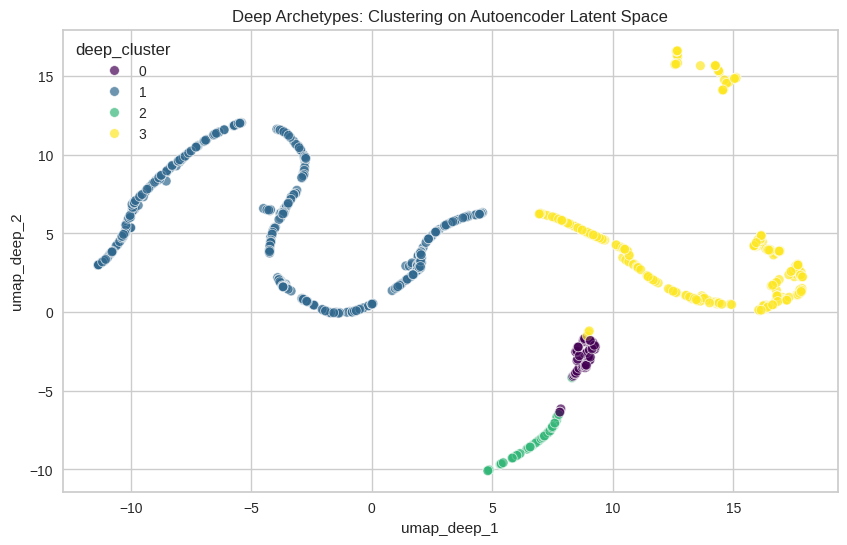

In [38]:
# 1. Create the Encoder-only model
encoder_only = models.Model(inputs=autoencoder.input,
                             outputs=autoencoder.get_layer('latent_space').output)

# 2. Extract the Deep (Latent) Features
latent_features = encoder_only.predict(df_active_scaled)

# 3. New K-Means on these Deep Features
kmeans_deep = KMeans(n_clusters=4, random_state=42, n_init=10)
df_active['deep_cluster'] = kmeans_deep.fit_predict(latent_features)

# 4. UMAP again (this time on the Deep Features)
reducer_deep = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_deep = reducer_deep.fit_transform(latent_features)

df_active['umap_deep_1'] = umap_deep[:, 0]
df_active['umap_deep_2'] = umap_deep[:, 1]

# 5. Final Comparison Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_active, x='umap_deep_1', y='umap_deep_2',
                hue='deep_cluster', palette='viridis', alpha=0.7)
plt.title("Deep Archetypes: Clustering on Autoencoder Latent Space")
plt.show()

In [43]:
# Check for languages that changed from Baseline to Deep clusters
# This identifies languages where the technical DNA (Autoencoder) overrode the surface metrics
changes = df_active[df_active['baseline_cluster'] != df_active['deep_cluster']]
print(f"Number of languages that shifted archetypes: {len(changes)}")
print(changes[['title', 'baseline_cluster', 'deep_cluster']].head(10))

Number of languages that shifted archetypes: 923
        title  baseline_cluster  deep_cluster
0        Java                 1             2
1  JavaScript                 1             2
2           C                 1             2
3      Python                 1             2
4         SQL                 1             2
5         C++                 1             2
6        HTML                 1             2
7         XML                 1             2
8         PHP                 1             2
9        Perl                 1             2


Business Interpretection

In [40]:
# View the top languages in each Deep Cluster to name the archetypes
for i in range(4):
    print(f"\n--- Cluster {i} Representative Languages ---")
    subset = df_active[df_active['deep_cluster'] == i]
    # Sorting by a mix of jobs and stars to see the leaders
    print(subset.sort_values(by='number_of_jobs', ascending=False)['title'].head(5).tolist())


--- Cluster 0 Representative Languages ---
['Kotlin', 'TypeScript', 'Solidity', 'x86-64', 'Elixir']

--- Cluster 1 Representative Languages ---
['Node.js', 'Liquid', 'Rholang', 'scribble', 'k-framework']

--- Cluster 2 Representative Languages ---
['HTTP', 'SQL', 'Java', 'HTML', 'JavaScript']

--- Cluster 3 Representative Languages ---
['Tag Line Commands', 'neutron', 'remix', 'quaint-lang', 'preforth']


Archetype Branding & Interpretation
Cluster 2: The Market Titans (High Utility, High Hype)

Members: SQL, Java, JavaScript, HTML, HTTP.

Interpretation: These are the infrastructure of the modern web and data world. They have the highest job counts and massive social visibility. They represent the "Safe Bets" for any developer or firm.

Cluster 0: The Modern Trendsetters (High Hype, Rising Utility)

Members: Kotlin, TypeScript, Solidity, Elixir.

Interpretation: These are "New-Era" languages. They have high GitHub engagement and are technically robust (captured by your Autoencoder). They are transitioning from "trendy" to "essential," particularly in mobile (Kotlin), web (TS), and Web3 (Solidity).

Cluster 1: Technical Specialists (Niche Utility)

Members: Node.js, Liquid, k-framework.

Interpretation: These represent specific ecosystems (e.g., Shopify’s Liquid or server-side JS). They aren't general-purpose "Titans," but they have dedicated professional pockets and specific technical DNA that the Autoencoder recognized.

Cluster 3: The Long-Tail / Speculative (Experimental)

Members: Remix, Quaint-lang, Preforth.

Interpretation: Even within the "Active" subset, these are languages with low professional demand but some social or technical activity. They represent the "Experimental" fringe of the ecosystem.

Refined Problem Statement and Reflection

Challenge: My original analysis was hindered by 97% zero-job data and linear models (PCA) that couldn't distinguish between "Famous" and "Useful" languages.

Action: I narrowed the scope to 953 "Active Market" languages and implemented a Deep Learning Autoencoder to extract the "Latent DNA" of the ecosystem.

Reflection: The Autoencoder revealed that technical structure is a major predictor of archetype. While Cluster 2 (Titans) is obvious, Cluster 0 (Modern Trendsetters) is the most valuable discovery. These languages (like Kotlin and Solidity) have the technical foundation of Titans but are still in their growth phase.

Business Value: This model allows stakeholders to look past "Hype" and see which technologies have the technical robustness to provide long-term professional stability.